# **Bluebikes Demand Forecasting with Weather and MBTA Proximity for Operational Planning**

Team B05: Mohamad Gong, Marcus Shi, Tianqi Sun, Tzu-Jen Chen, Arshdeep Oberoi, Xiaoqing Ye



## Executive Summary

Bluebikes has become a high volume part of Boston’s mobility network, with clear peaks in summer and steady contribution from members throughout the year. Demand responds strongly to temperature and severe weather, which creates predictable high and low periods that operations can plan around. The system is tightly linked to MBTA, with many trips starting or ending near rapid transit, which confirms Bluebikes’ role in first and last mile access. A simple BigQuery ML model can flag likely high demand days in advance using recent demand, calendar effects, and temperature. Together, the analytical tables and dashboards give stakeholders a repeatable view of where and when to focus docks, bikes, and staff.

## Problem Definition

Our project equips Boston’s Bluebikes stakeholders with a repeatable, data-driven view of when and where demand materializes, and how it responds to weather and MBTA proximity.

*   Profile system and station-level usage patterns across time, user type, and geography to size the demand landscape.

*   Quantify relationships between temperature, precipitation, and station demand to understand climate risk and resilience.

*   Train a BigQuery ML model to forecast near-term demand by station under different weather scenarios.

*   Assess MBTA rapid-transit proximity and first- and last-mile roles to prioritize rebalancing, capacity upgrades, and new station locations, feeding a monitoring dashboard.


## Motivation

By combining interoperable public datasets on Bluebikes trips, weather, and MBTA proximity, we will deliver actionable guidance on station placement, rebalancing, and first and last mile reliability for Boston’s mobility stakeholders. As BU students who ride Bluebikes, we are personally invested in a more convenient, equitable, and dependable system.

# **1. Data Model and Dashboard Overview**


## 2.1 Entity-Relationship Diagram (ERD)

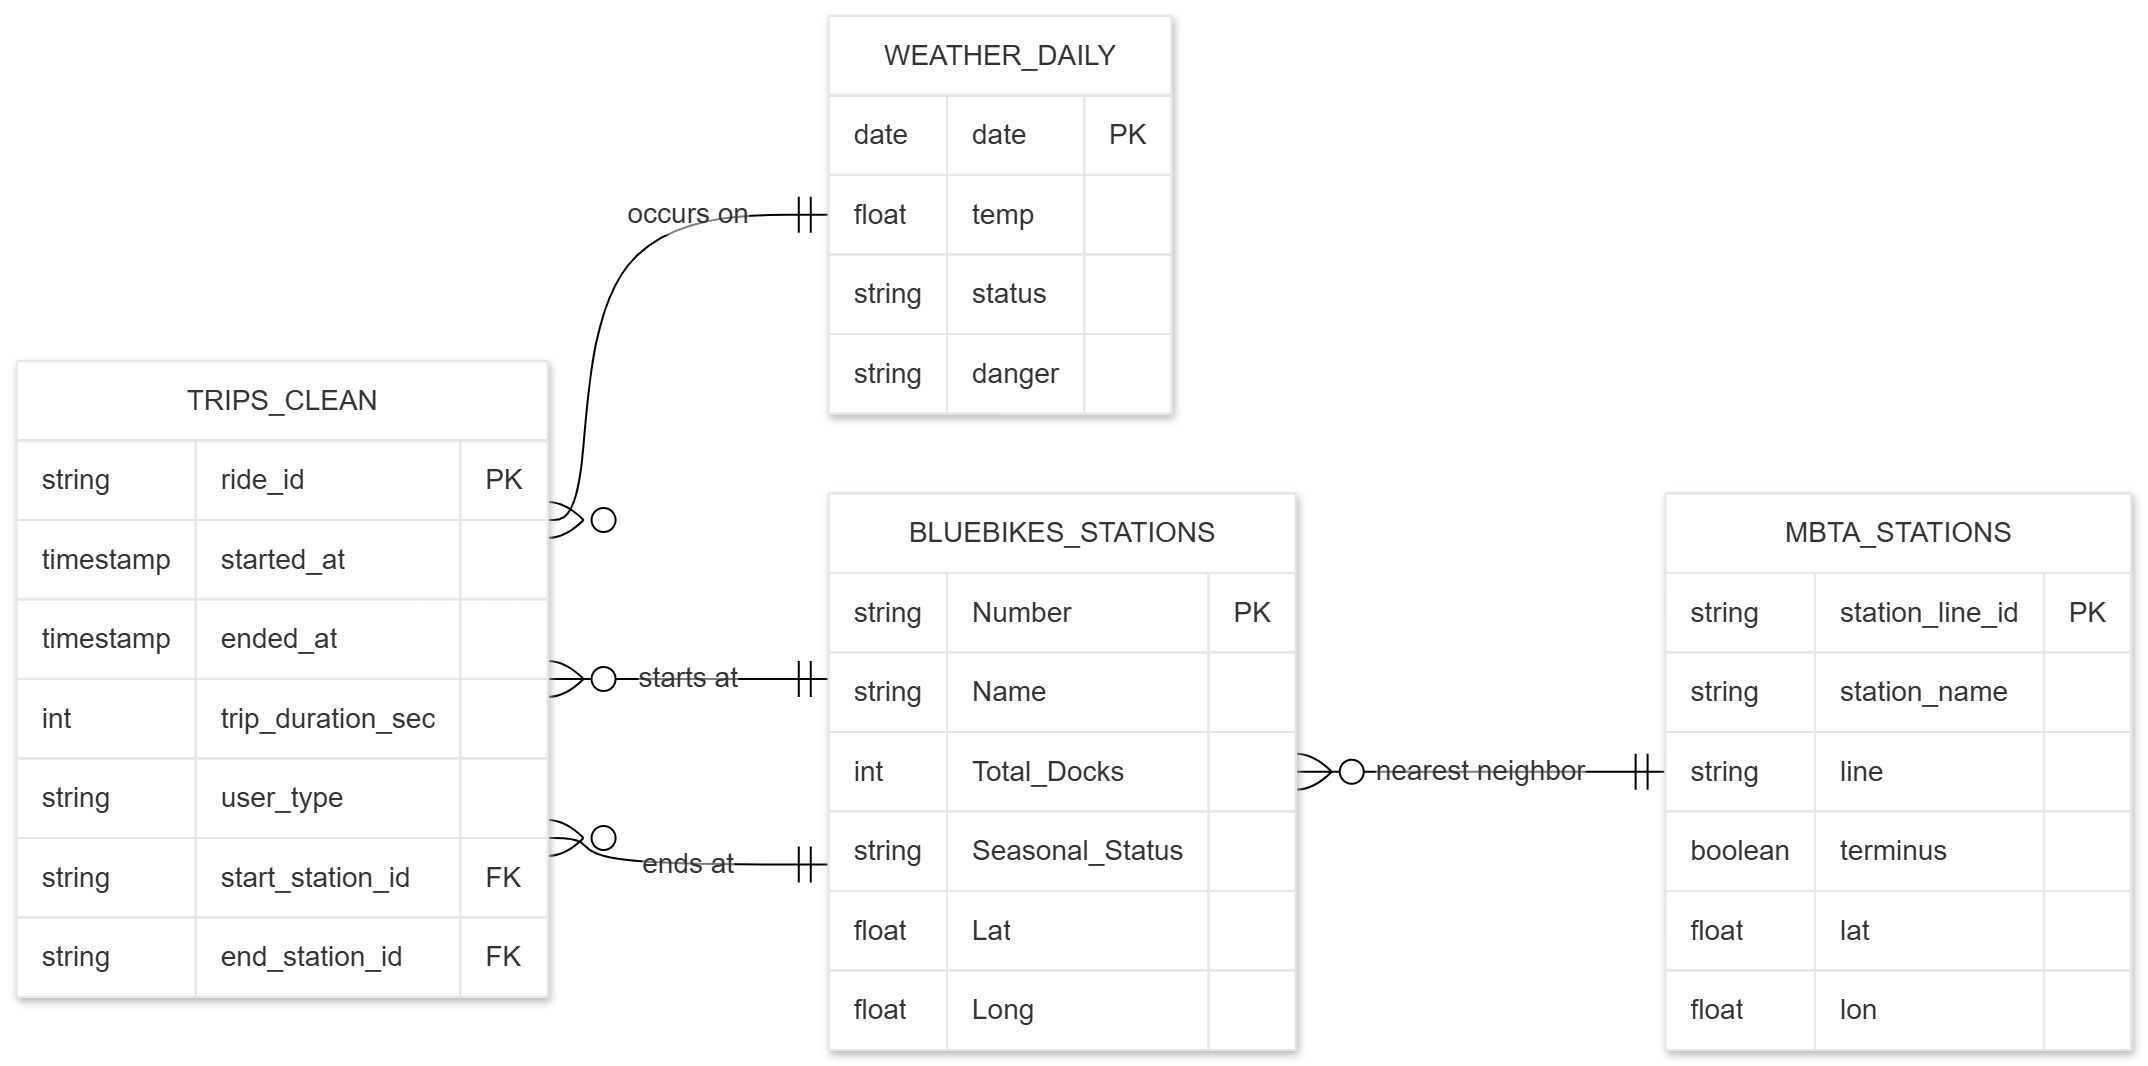

## 2.2 Dashboard Design and Screenshots


https://lookerstudio.google.com/reporting/a46c0cd9-3a98-44bd-86d8-cf6c015e8c10

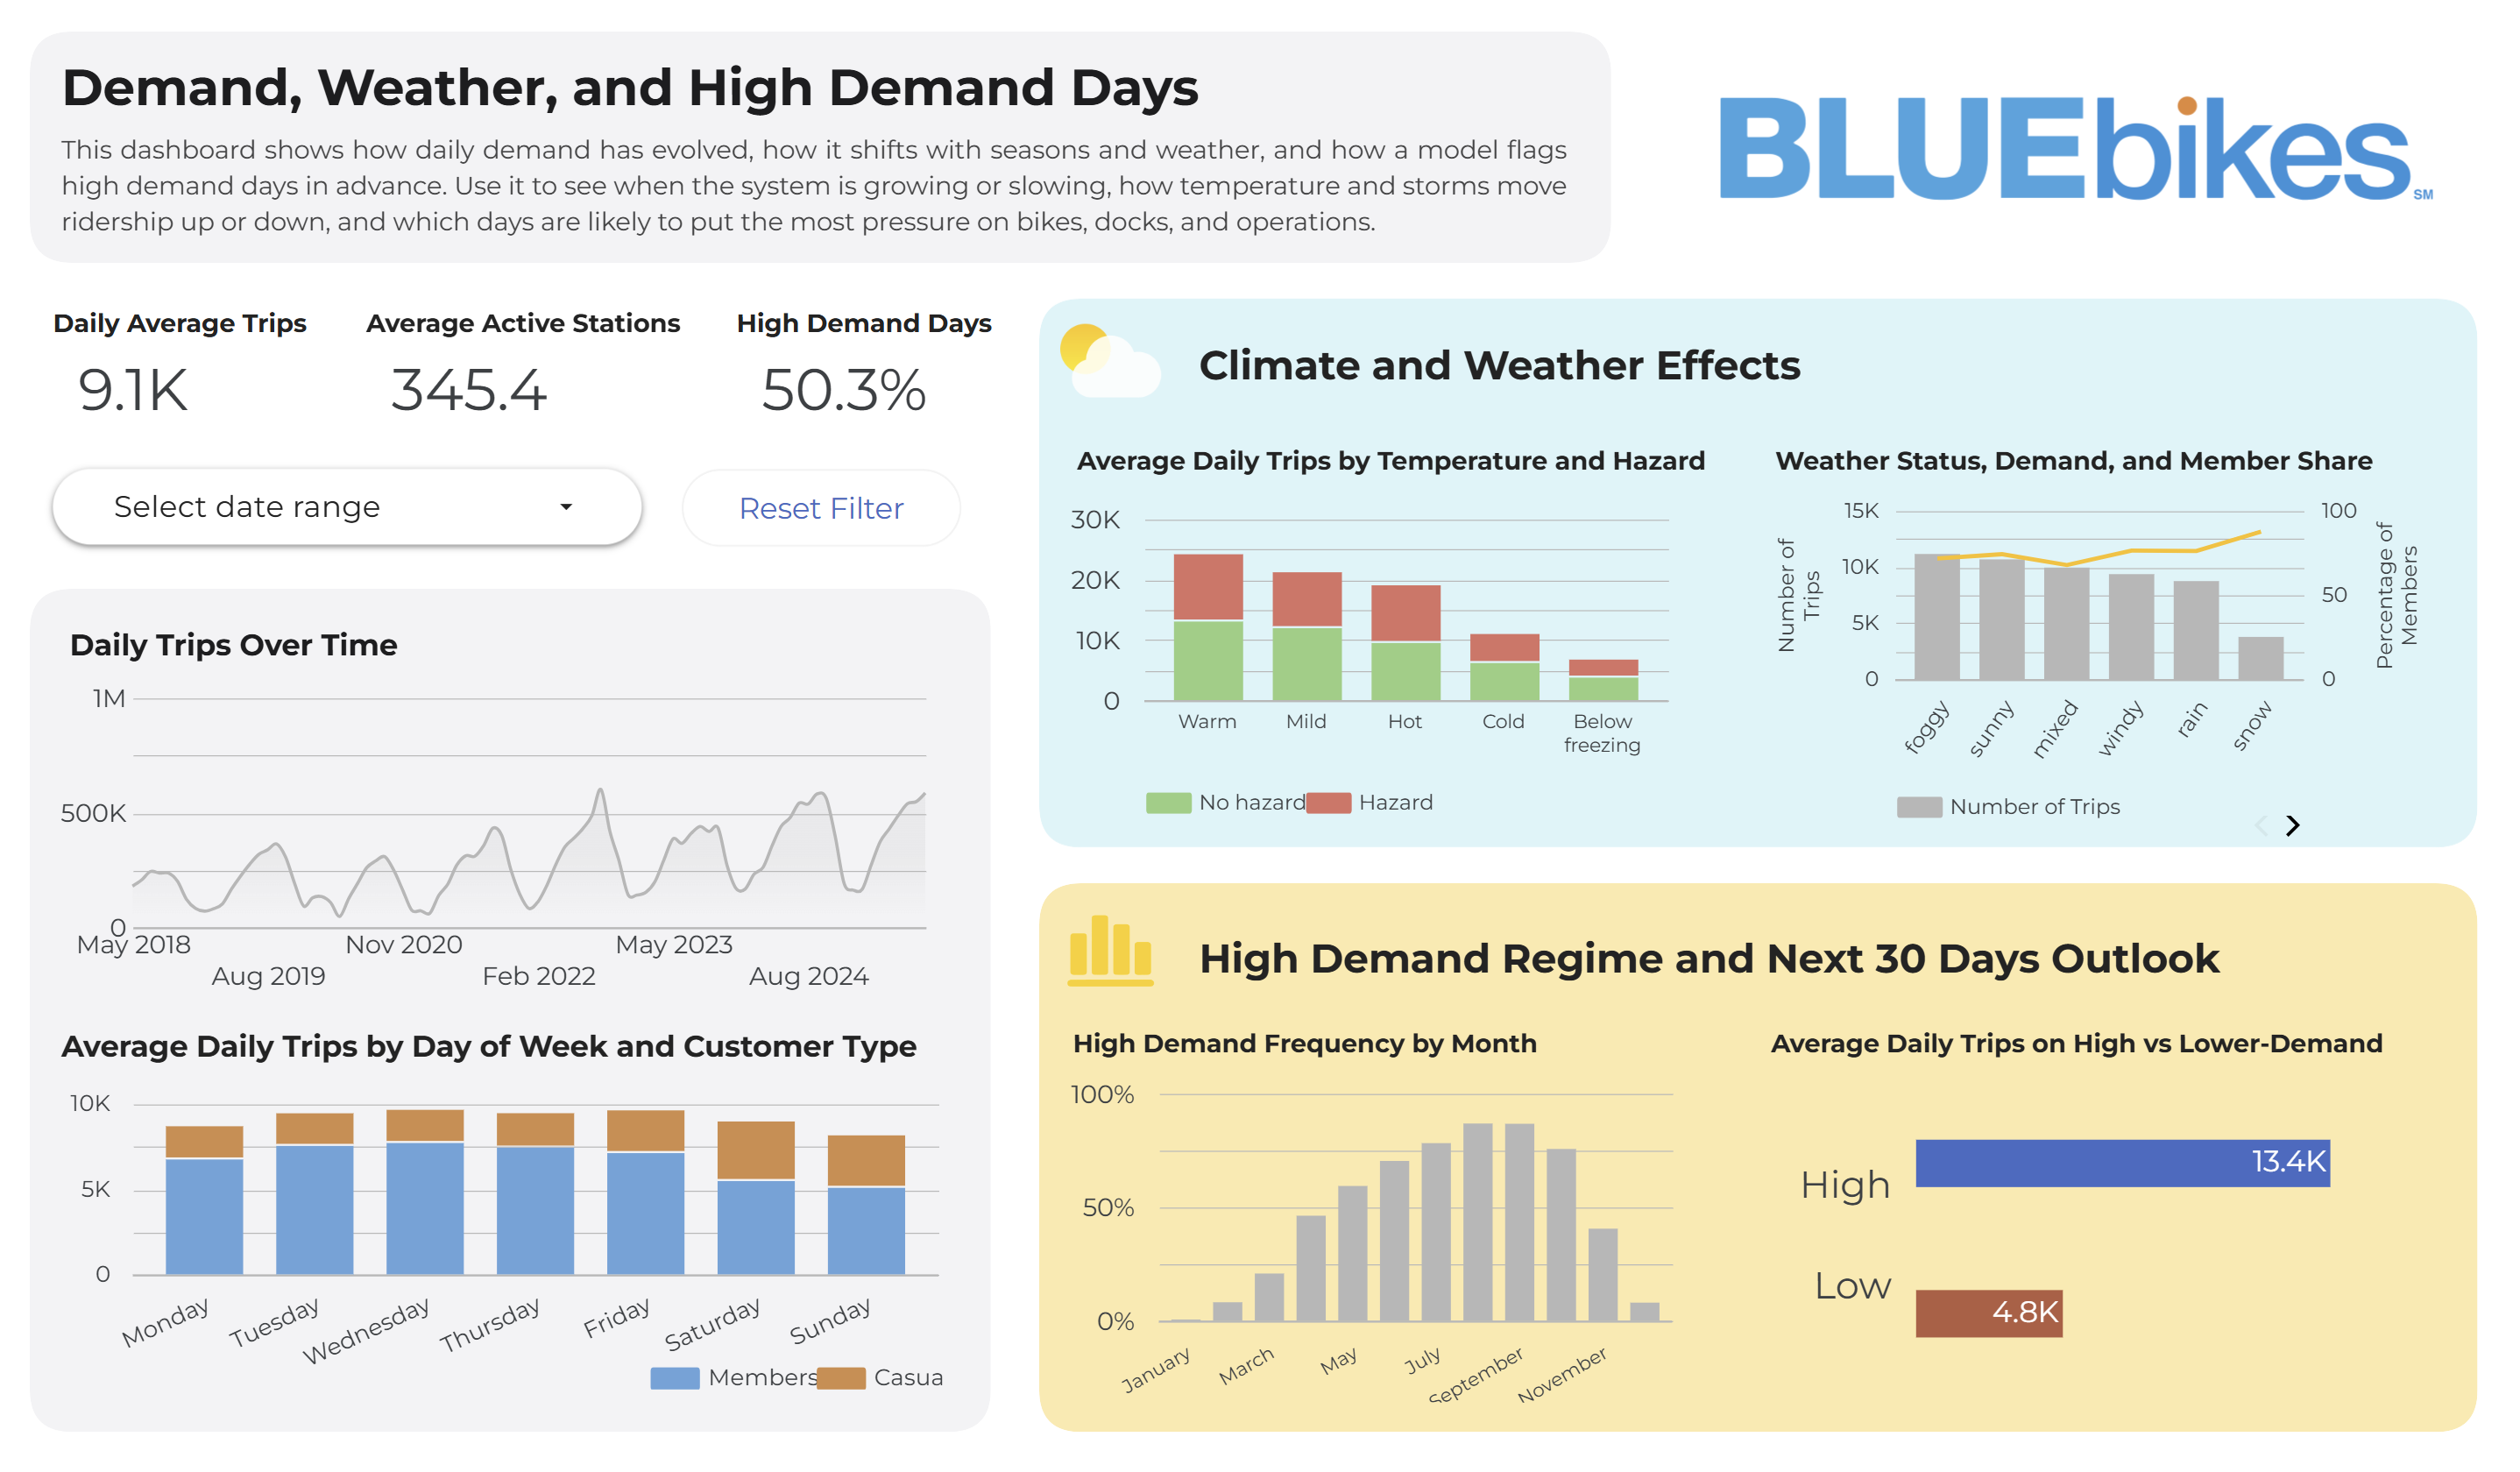

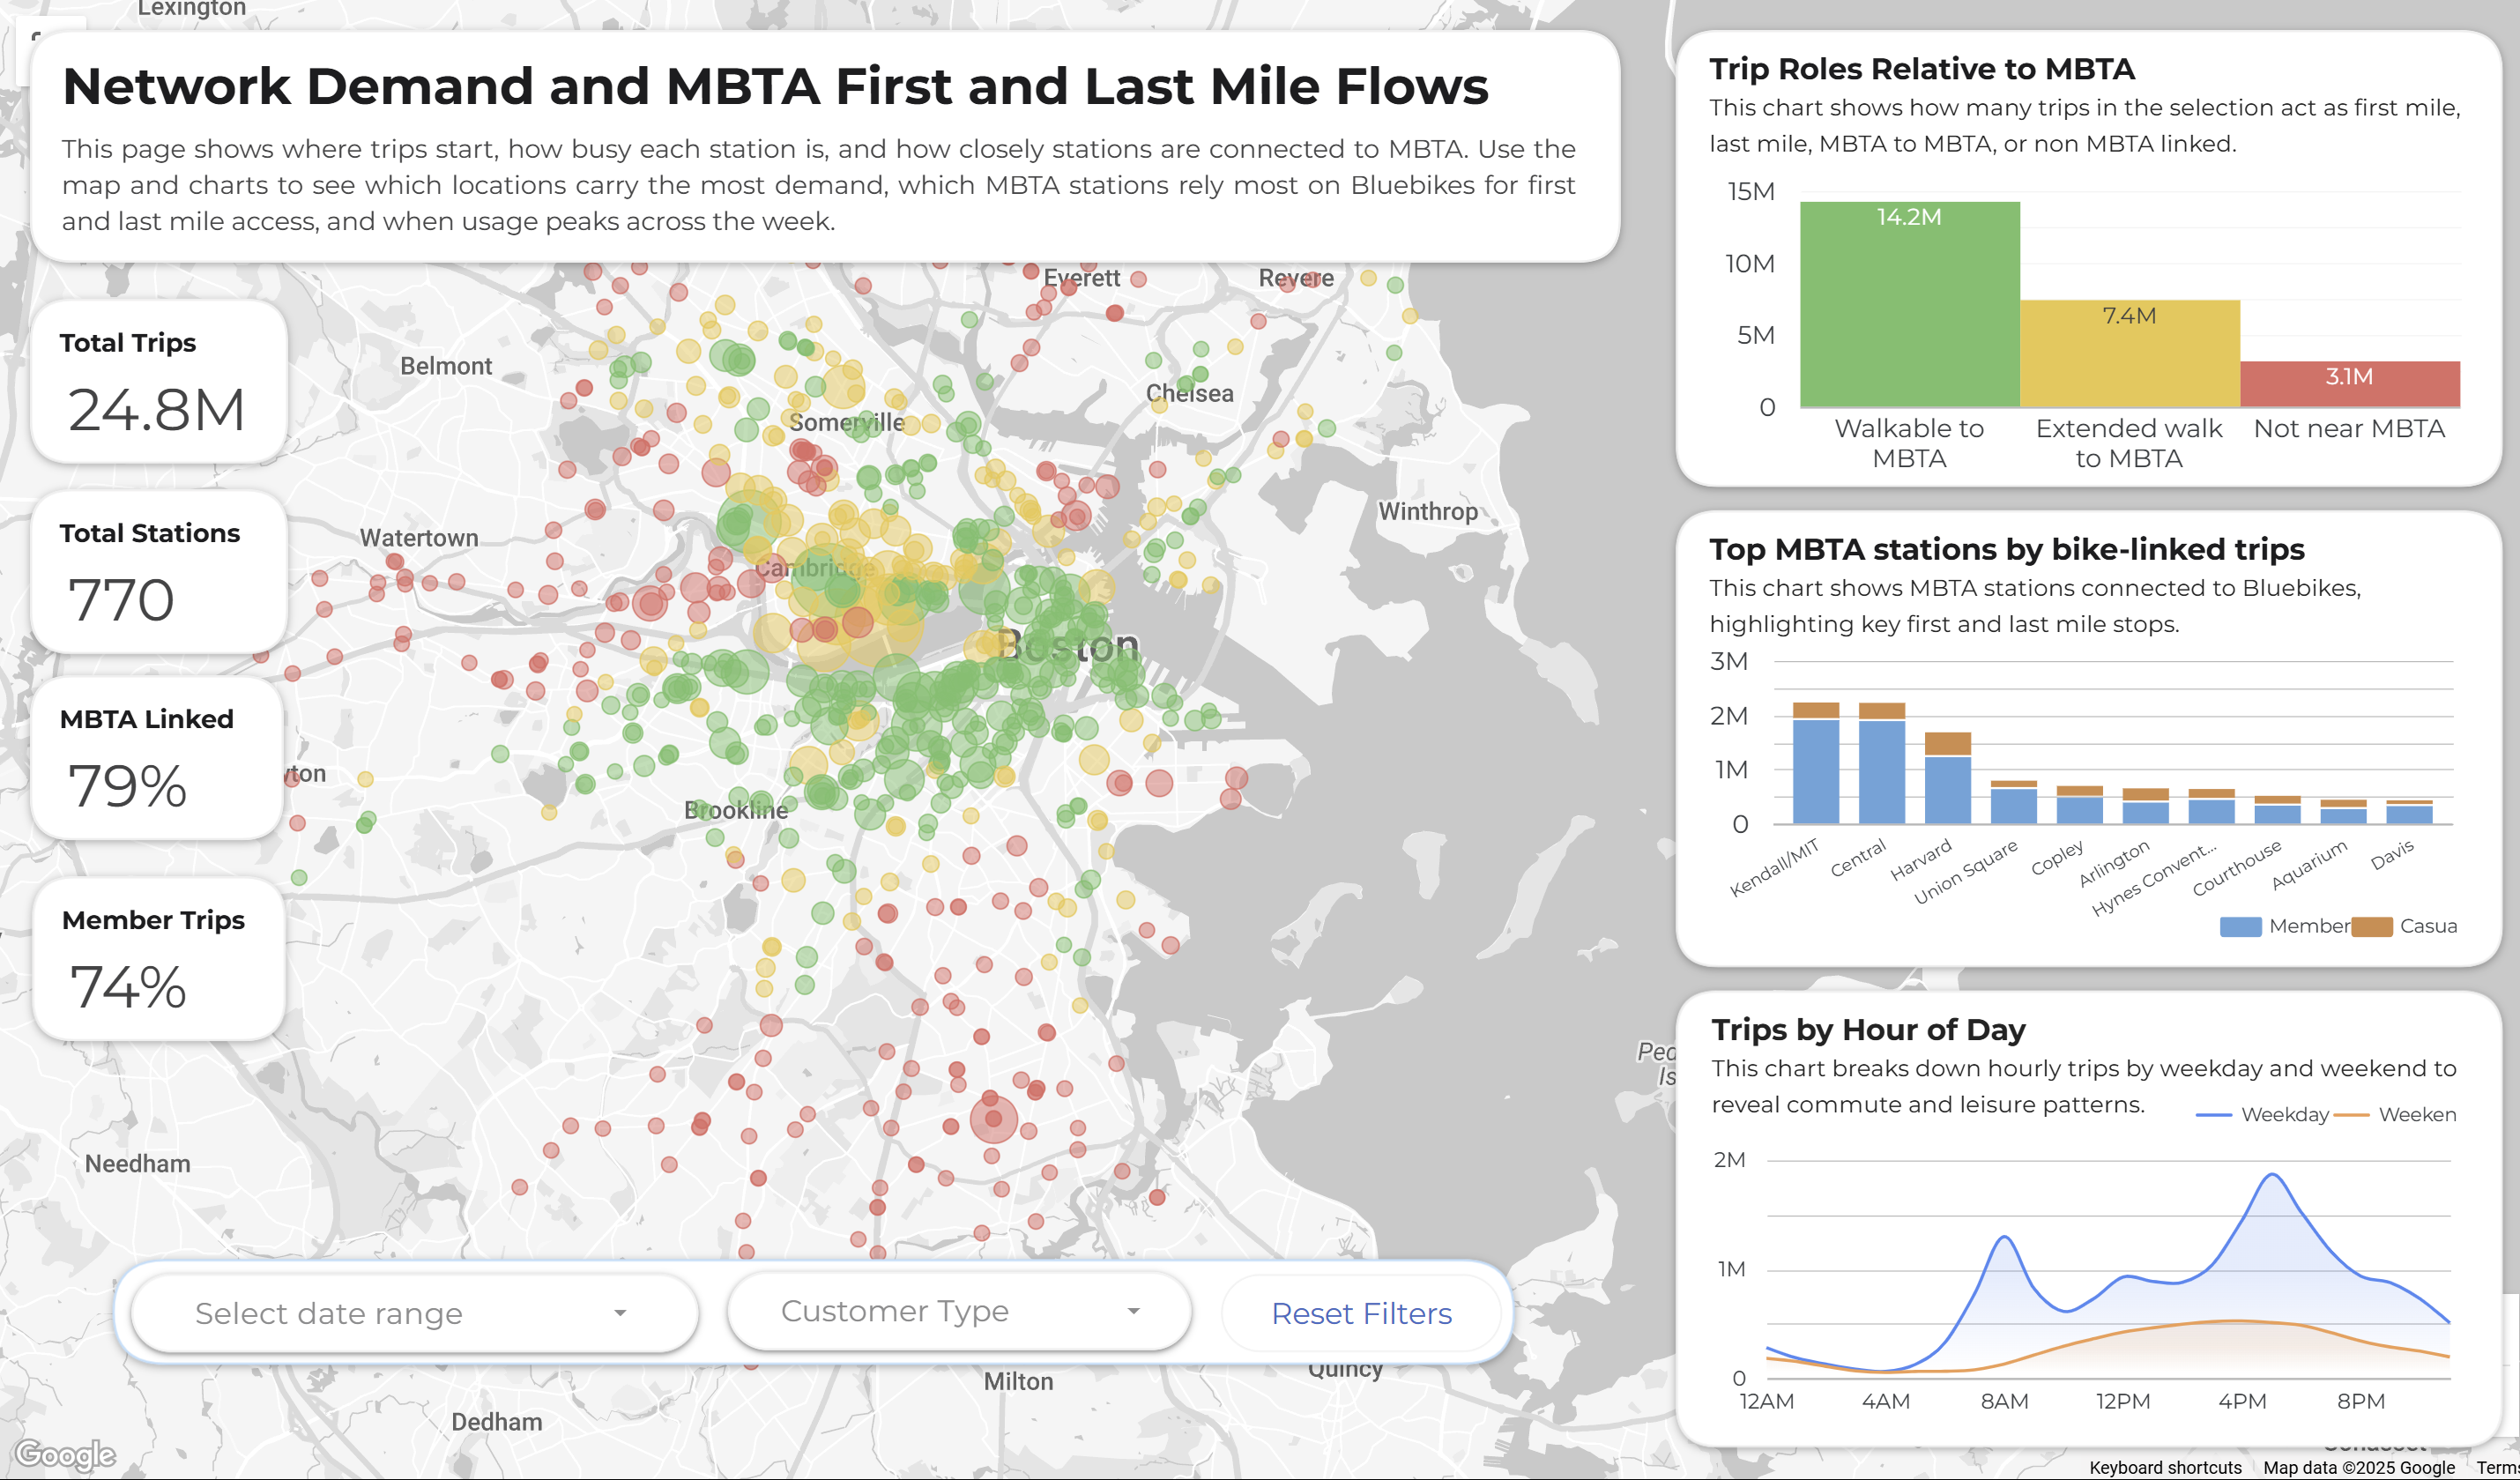

# **2. Data Sources**

**Bluebikes Trip Data:**

Trip-level records of bike-share rides from Boston’s public bike-share system, originally launched as Hubway in 2011 and rebranded as Bluebikes in May 2018 following a new sponsorship agreement with Blue Cross Blue Shield of Massachusetts. The dataset documents individual trips between docking stations, including trip start and end times, station names and IDs, bike IDs, and trip durations, published as monthly zipped CSV files. For this project, we include data only from May 2018 onward to align with the Bluebikes era, ensuring a consistent system brand, operator, station network, and pricing/technology environment; earlier Hubway-period data are excluded for analytical continuity.

The data has been processed to remove trips that are taken by staff as they service and inspect the system; and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it was secure).

**Coverage:** May 2018–Sep 2025

**Format:** CSV (monthly zip archives)

**Size:** ~2.4 GB

**Link:** https://s3.amazonaws.com/hubway-data/index.html


---


**Bluebikes Station List:**

Official list of active Bluebikes docking stations, published and maintained by the Bluebikes program. Each record includes station ID, name, geographic coordinates, municipality, and total number of docks. Designed to support spatial joins with trip and demographic data.

**Coverage:** August 2025 (current active station network)

**Format:** CSV

**Size:** 0.08 MB

**Link:** https://bluebikes.com/system-data



---



**Weather Data:**

Daily and hourly weather observations from official NWS/NCEI stations, including temperature, wind, precipitation, snowfall, and coded weather conditions. Used to construct one record per day with key metrics (e.g., average temperature, rain/snow indicators, and simple hazard flags) for integrating weather context into ridership analyses.

**Coverage:** Station-specific, multi-year through 2025

**Format:** CSV (hourly + daily summaries)

**Size:** Varies by station and period (~5–50 MB per station)

**Link:** https://www.ncei.noaa.gov/cdo-web/datatools/



---



**MBTA Rapid Transit Stations Data:**

Point locations of MBTA rapid-transit stations (subway and light-rail) with station names, lines, and geographic coordinates, used to measure Bluebikes station proximity and analyze first- and last-mile connections to the transit network.

**Coverage:** Current MBTA rapid-transit station network (downloaded 2025)

**Format:** CSV

**Size:** 17 KB

**Link:** https://www.mass.gov/info-details/massgis-data-mbta-rapid-transit/

# **3. Data Importing and Cleaning**

## 3.1 Importing Data

For this project, all analysis was done on Google Cloud using Cloud Storage for raw data and BigQuery for warehousing and queries. Most tables were imported via the BigQuery web interface for simplicity. The exception was the trips data: it spans 89 monthly CSV files with occasional column-name/schema differences, so we used Cloud Shell to bulk load from Cloud Storage into a single BigQuery table. This approach (using `gsutil` + `bq` load with schema autodetection and allowed schema updates) handled the file count and minor schema drift reliably and reproducibly.

```
gcloud config set project ba775-fall25-b05

PROJECT_ID=ba775-fall25-b05
DATASET=bluebikes
TABLE=trips
BUCKET=gs://ba775-fall25-b05/trip_history

# create/overwrite the table using the first file (sorted so 201805 loads first)
FIRST_URI=$(gsutil ls "$BUCKET/*.csv" | sort | head -n 1)
bq load \
  --source_format=CSV \
  --autodetect \
  --skip_leading_rows=1 \
  --replace \
  "$PROJECT_ID:$DATASET.$TABLE" \
  "$FIRST_URI"

# append the rest, allowing small schema changes over time
for URI in $(gsutil ls "$BUCKET/*.csv" | sort | tail -n +2); do
  bq load \
    --source_format=CSV \
    --autodetect \
    --skip_leading_rows=1 \
    --schema_update_option=ALLOW_FIELD_ADDITION \
    --schema_update_option=ALLOW_FIELD_RELAXATION \
    "$PROJECT_ID:$DATASET.$TABLE" \
    "$URI"
done
```



## 3.2 Data Cleaning

### Trips Data

The first step would be to inspect the trips table.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.bluebikes.trips`
LIMIT
  5
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=5, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.bluebikes`.INFORMATION_SCHEMA.COLUMNS
WHERE
  table_name = 'trips'
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=29, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

After inspecting the combined trips table, we found duplicate columns with slightly different names (e.g., `start_station_name` vs. `start station name`). This inconsistency comes from the monthly source files, which were published as separate tables with varying column names and orders. The next step is to standardize the schema and merge these semantically equivalent columns into single, consistent fields.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE
  `ba775-fall25-b05.ba775_fall25_b05.trips_clean` AS
SELECT
  ride_id,
  rideable_type,
  COALESCE(started_at, starttime) AS started_at,
  COALESCE(ended_at, stoptime) AS ended_at,
  COALESCE( tripduration, SAFE_CAST(TIMESTAMP_DIFF(COALESCE(ended_at, stoptime), COALESCE(started_at, starttime), SECOND) AS INT64) ) AS trip_duration_sec,
  COALESCE(start_station_id, CAST(`start station id` AS STRING)) AS start_station_id,
  COALESCE(start_station_name, `start station name`) AS start_station_name,
  COALESCE(start_lat, `start station latitude`) AS start_lat,
  COALESCE(start_lng, `start station longitude`) AS start_lng,
  COALESCE(end_station_id, CAST(`end station id` AS STRING)) AS end_station_id,
  COALESCE(end_station_name, `end station name`) AS end_station_name,
  COALESCE(end_lat, `end station latitude`) AS end_lat,
  COALESCE(end_lng, `end station longitude`) AS end_lng,
  member_casual,
  usertype,
  CAST(bikeid AS STRING) AS bike_id,
  `postal code` AS postal_code,
  `birth year` AS birth_year,
  gender
FROM
  `ba775-fall25-b05.bluebikes.trips`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
LIMIT
  5
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=5, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
where end_station_id is null
LIMIT
  5
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=5, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  EXTRACT(YEAR  FROM DATE(started_at)) AS yr,
  EXTRACT(MONTH FROM DATE(started_at)) AS mo,

  SUM(CASE WHEN ride_id IS NULL THEN 1 ELSE 0 END) AS ride_id_nulls,
  SUM(CASE WHEN ride_id IS NOT NULL THEN 1 ELSE 0 END) AS ride_id_not_nulls,

  SUM(CASE WHEN rideable_type IS NULL THEN 1 ELSE 0 END) AS rideable_type_nulls,
  SUM(CASE WHEN rideable_type IS NOT NULL THEN 1 ELSE 0 END) AS rideable_type_not_nulls,

  SUM(CASE WHEN started_at IS NULL THEN 1 ELSE 0 END) AS started_at_nulls,
  SUM(CASE WHEN started_at IS NOT NULL THEN 1 ELSE 0 END) AS started_at_not_nulls,

  SUM(CASE WHEN ended_at IS NULL THEN 1 ELSE 0 END) AS ended_at_nulls,
  SUM(CASE WHEN ended_at IS NOT NULL THEN 1 ELSE 0 END) AS ended_at_not_nulls,

  SUM(CASE WHEN trip_duration_sec IS NULL THEN 1 ELSE 0 END) AS trip_duration_sec_nulls,
  SUM(CASE WHEN trip_duration_sec IS NOT NULL THEN 1 ELSE 0 END) AS trip_duration_sec_not_nulls,

  SUM(CASE WHEN start_station_id IS NULL THEN 1 ELSE 0 END) AS start_station_id_nulls,
  SUM(CASE WHEN start_station_id IS NOT NULL THEN 1 ELSE 0 END) AS start_station_id_not_nulls,

  SUM(CASE WHEN start_station_name IS NULL THEN 1 ELSE 0 END) AS start_station_name_nulls,
  SUM(CASE WHEN start_station_name IS NOT NULL THEN 1 ELSE 0 END) AS start_station_name_not_nulls,

  SUM(CASE WHEN start_lat IS NULL THEN 1 ELSE 0 END) AS start_lat_nulls,
  SUM(CASE WHEN start_lat IS NOT NULL THEN 1 ELSE 0 END) AS start_lat_not_nulls,

  SUM(CASE WHEN start_lng IS NULL THEN 1 ELSE 0 END) AS start_lng_nulls,
  SUM(CASE WHEN start_lng IS NOT NULL THEN 1 ELSE 0 END) AS start_lng_not_nulls,

  SUM(CASE WHEN end_station_id IS NULL THEN 1 ELSE 0 END) AS end_station_id_nulls,
  SUM(CASE WHEN end_station_id IS NOT NULL THEN 1 ELSE 0 END) AS end_station_id_not_nulls,

  SUM(CASE WHEN end_station_name IS NULL THEN 1 ELSE 0 END) AS end_station_name_nulls,
  SUM(CASE WHEN end_station_name IS NOT NULL THEN 1 ELSE 0 END) AS end_station_name_not_nulls,

  SUM(CASE WHEN end_lat IS NULL THEN 1 ELSE 0 END) AS end_lat_nulls,
  SUM(CASE WHEN end_lat IS NOT NULL THEN 1 ELSE 0 END) AS end_lat_not_nulls,

  SUM(CASE WHEN end_lng IS NULL THEN 1 ELSE 0 END) AS end_lng_nulls,
  SUM(CASE WHEN end_lng IS NOT NULL THEN 1 ELSE 0 END) AS end_lng_not_nulls,

  SUM(CASE WHEN member_casual IS NULL THEN 1 ELSE 0 END) AS member_casual_nulls,
  SUM(CASE WHEN member_casual IS NOT NULL THEN 1 ELSE 0 END) AS member_casual_not_nulls,

  SUM(CASE WHEN usertype IS NULL THEN 1 ELSE 0 END) AS usertype_nulls,
  SUM(CASE WHEN usertype IS NOT NULL THEN 1 ELSE 0 END) AS usertype_not_nulls,

  SUM(CASE WHEN bike_id IS NULL THEN 1 ELSE 0 END) AS bike_id_nulls,
  SUM(CASE WHEN bike_id IS NOT NULL THEN 1 ELSE 0 END) AS bike_id_not_nulls,

  SUM(CASE WHEN postal_code IS NULL THEN 1 ELSE 0 END) AS postal_code_nulls,
  SUM(CASE WHEN postal_code IS NOT NULL THEN 1 ELSE 0 END) AS postal_code_not_nulls,

  SUM(CASE WHEN birth_year IS NULL THEN 1 ELSE 0 END) AS birth_year_nulls,
  SUM(CASE WHEN birth_year IS NOT NULL THEN 1 ELSE 0 END) AS birth_year_not_nulls,

  SUM(CASE WHEN gender IS NULL THEN 1 ELSE 0 END) AS gender_nulls,
  SUM(CASE WHEN gender IS NOT NULL THEN 1 ELSE 0 END) AS gender_not_nulls

FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
GROUP BY yr, mo
ORDER BY yr, mo;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=89, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

After inspecting the data, the following steps will be taken next:

`ride_id`: This field was not recorded until April 2023. For records where it is missing, a value will be generated using a deterministic hash of timestamps, station identifiers, and bike_id so that identifiers remain stable across rebuilds.

`rideable_type` and `bike_id`: These two fields were not recorded until April 2023. They will be kept exactly as present in the source data, and no values will be inferred for earlier periods.

Datetime fields (`started_at`, `ended_at`): These fields are complete and will be left unchanged.

Start-station fields (`start_station_id`, `start_station_name`, `start_lat`, `start_lng`): Because trips without a beginning cannot be used in analysis, rows with any missing start-station value will be removed.

End-station fields (`end_station_id`, `end_station_name`, `end_lat`, `end_lng`): Because trips without a destination cannot be used in destination analysis, rows with any missing end-station value will be removed.

User type: A single unified column named `user_type` will be created. Values will be taken from `member_casual` when available; otherwise, legacy `usertype` will be mapped so that Subscriber and Member become member, and Customer and Casual become casual. The original two columns may then be dropped from the final table.

`postal_code`: Because this field is largely missing from May 2020 through April 2023 and is redundant with latitude and longitude, it will be dropped.

`birth_year` and `gender`: Because these fields stopped being recorded in May 2020, they will be dropped.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE
  `ba775-fall25-b05.ba775_fall25_b05.trips_clean` AS
WITH
  base AS (
  SELECT
    COALESCE( ride_id, TO_HEX(SHA256(CONCAT( CAST(started_at AS STRING), '|', CAST(ended_at AS STRING), '|', IFNULL(start_station_id, ''), '|', IFNULL(end_station_id, ''), '|', IFNULL(bike_id, '') ))) ) AS ride_id,
    rideable_type,
    bike_id,
    started_at,
    ended_at,
    trip_duration_sec,
    start_station_id,
    start_station_name,
    start_lat,
    start_lng,
    end_station_id,
    end_station_name,
    end_lat,
    end_lng,
    COALESCE( member_casual,
      CASE
        WHEN LOWER(usertype) IN ('subscriber', 'member') THEN 'member'
        WHEN LOWER(usertype) IN ('customer',
        'casual') THEN 'casual'
        ELSE NULL
    END
      ) AS user_type
  FROM
    `ba775-fall25-b05.ba775_fall25_b05.trips_clean` )
SELECT
  *
FROM
  base
WHERE
  start_station_id IS NOT NULL
  AND start_station_name IS NOT NULL
  AND start_lat IS NOT NULL
  AND start_lng IS NOT NULL
  AND end_station_id IS NOT NULL
  AND end_station_name IS NOT NULL
  AND end_lat IS NOT NULL
  AND end_lng IS NOT NULL;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

### Stations Data

When inspecting the stations table it appears there is a legacy numbering, and that is backed up when inspecting the station IDs in the trips table.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.bluebikes.stations`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=572, table_html='<table border="1" class="dataframe table table-striped ta…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.bluebikes`.INFORMATION_SCHEMA.COLUMNS
WHERE
  table_name = 'stations'
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=8, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

For that we will replace the old station ID with the new one if possible, and add Seasonal Status and Total Docks.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.ba775_fall25_b05.trips_clean` AS
SELECT
  t.ride_id,
  t.rideable_type,
  t.bike_id,
  t.started_at,
  t.ended_at,
  t.trip_duration_sec,

  COALESCE(s_start.Number, t.start_station_id) AS start_station_id,
  t.start_station_name,
  t.start_lat,
  t.start_lng,

  COALESCE(s_end.Number, t.end_station_id)     AS end_station_id,
  t.end_station_name,
  t.end_lat,
  t.end_lng,

  t.user_type,

  s_start.`Seasonal Status` AS start_seasonal_status,
  CAST(s_start.`Total Docks` AS INT64) AS start_total_docks,
  s_end.`Seasonal Status`   AS end_seasonal_status,
  CAST(s_end.`Total Docks` AS INT64)   AS end_total_docks
FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean` t
LEFT JOIN `ba775-fall25-b05.bluebikes.stations` s_start
  ON t.start_station_name = s_start.NAME
 AND ROUND(t.start_lat, 4) = ROUND(s_start.Lat, 4)
 AND ROUND(t.start_lng, 4) = ROUND(s_start.Long, 4)
LEFT JOIN `ba775-fall25-b05.bluebikes.stations` s_end
  ON t.end_station_name = s_end.NAME
 AND ROUND(t.end_lat, 4) = ROUND(s_end.Lat, 4)
 AND ROUND(t.end_lng, 4) = ROUND(s_end.Long, 4);
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
WITH unmapped AS (
  SELECT start_station_id AS station_id
  FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean` t
  LEFT JOIN `ba775-fall25-b05.bluebikes.stations` s
    ON t.start_station_id = s.Number
  WHERE s.Number IS NULL
  UNION ALL
  SELECT end_station_id
  FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean` t
  LEFT JOIN `ba775-fall25-b05.bluebikes.stations` s
    ON t.end_station_id = s.Number
  WHERE s.Number IS NULL
)
SELECT station_id, COUNT(*) AS trips
FROM unmapped
GROUP BY station_id
ORDER BY trips DESC;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=200, table_html='<table border="1" class="dataframe table table-striped ta…

Computation deferred. Computation will process 0 Bytes

As it appears, many stations did not match the stations table, and that is acceptable. The trips still retain station name and coordinates (latitude and longitude), which allow station-level analysis. The only information missing for unmatched rows is Seasonal Status and Total Docks, which are supplementary fields; the core trip records remain usable for the analysis.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE
  `ba775-fall25-b05.ba775_fall25_b05.trips_clean` AS
WITH
  src AS (
  SELECT
    *
  FROM
    `ba775-fall25-b05.ba775_fall25_b05.trips_clean` )
SELECT
  ride_id,
  started_at,
  ended_at,
  trip_duration_sec,
  rideable_type,
  bike_id,
  user_type,
  start_station_id,
  start_station_name,
  start_lat,
  start_lng,
  start_seasonal_status,
  start_total_docks,
  end_station_id,
  end_station_name,
  end_lat,
  end_lng,
  end_seasonal_status,
  end_total_docks
FROM
  src;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

Inspecting the final table after cleaning.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  EXTRACT(YEAR FROM started_at) AS year,
  EXTRACT(MONTH FROM started_at) AS month,

  -- ride_id
  COUNTIF(ride_id IS NULL) AS ride_id_null,
  COUNTIF(ride_id IS NOT NULL) AS ride_id_not_null,

  -- started_at
  COUNTIF(started_at IS NULL) AS started_at_null,
  COUNTIF(started_at IS NOT NULL) AS started_at_not_null,

  -- ended_at
  COUNTIF(ended_at IS NULL) AS ended_at_null,
  COUNTIF(ended_at IS NOT NULL) AS ended_at_not_null,

  -- trip_duration_sec
  COUNTIF(trip_duration_sec IS NULL) AS trip_duration_sec_null,
  COUNTIF(trip_duration_sec IS NOT NULL) AS trip_duration_sec_not_null,

  -- rideable_type
  COUNTIF(rideable_type IS NULL) AS rideable_type_null,
  COUNTIF(rideable_type IS NOT NULL) AS rideable_type_not_null,

  -- bike_id
  COUNTIF(bike_id IS NULL) AS bike_id_null,
  COUNTIF(bike_id IS NOT NULL) AS bike_id_not_null,

  -- user_type
  COUNTIF(user_type IS NULL) AS user_type_null,
  COUNTIF(user_type IS NOT NULL) AS user_type_not_null,

  -- start_station_id
  COUNTIF(start_station_id IS NULL) AS start_station_id_null,
  COUNTIF(start_station_id IS NOT NULL) AS start_station_id_not_null,

  -- start_station_name
  COUNTIF(start_station_name IS NULL) AS start_station_name_null,
  COUNTIF(start_station_name IS NOT NULL) AS start_station_name_not_null,

  -- start_lat / start_lng
  COUNTIF(start_lat IS NULL) AS start_lat_null,
  COUNTIF(start_lat IS NOT NULL) AS start_lat_not_null,

  COUNTIF(start_lng IS NULL) AS start_lng_null,
  COUNTIF(start_lng IS NOT NULL) AS start_lng_not_null,

  -- start_seasonal_status
  COUNTIF(start_seasonal_status IS NULL) AS start_seasonal_status_null,
  COUNTIF(start_seasonal_status IS NOT NULL) AS start_seasonal_status_not_null,

  -- start_total_docks
  COUNTIF(start_total_docks IS NULL) AS start_total_docks_null,
  COUNTIF(start_total_docks IS NOT NULL) AS start_total_docks_not_null,

  -- end_station_id
  COUNTIF(end_station_id IS NULL) AS end_station_id_null,
  COUNTIF(end_station_id IS NOT NULL) AS end_station_id_not_null,

  -- end_station_name
  COUNTIF(end_station_name IS NULL) AS end_station_name_null,
  COUNTIF(end_station_name IS NOT NULL) AS end_station_name_not_null,

  -- end_lat / end_lng
  COUNTIF(end_lat IS NULL) AS end_lat_null,
  COUNTIF(end_lat IS NOT NULL) AS end_lat_not_null,

  COUNTIF(end_lng IS NULL) AS end_lng_null,
  COUNTIF(end_lng IS NOT NULL) AS end_lng_not_null,

  -- end_seasonal_status
  COUNTIF(end_seasonal_status IS NULL) AS end_seasonal_status_null,
  COUNTIF(end_seasonal_status IS NOT NULL) AS end_seasonal_status_not_null,

  -- end_total_docks
  COUNTIF(end_total_docks IS NULL) AS end_total_docks_null,
  COUNTIF(end_total_docks IS NOT NULL) AS end_total_docks_not_null

FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
GROUP BY year, month
ORDER BY year, month;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=89, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

* Core trip fields (`ride_id`, timestamps, duration, user & station IDs/names, lat/lng) are fully populated with no NULL values across all months.
* Schema change in 2023-04: older data has `bike_id` filled and `rideable_type` always NULL; newer data has `rideable_type` filled and `bike_id` always NULL.
* Station metadata fields (`start_seasonal_status`, `end_seasonal_status`, `start_total_docks`, `end_total_docks`) have partial coverage and often go NULL together.
* The share of NULLs in these station metadata fields increases in more recent months, so analyses using capacity/seasonality should treat these as “unknown” or filter them out.

### Climate Data

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.weather`.INFORMATION_SCHEMA.COLUMNS
WHERE
  table_name = 'weather_raw'
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=11, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

From this, we generated one record per day with clear indicators for conditions like rain, snow, wind, or sun, and optional flags for extreme or hazardous weather. This cleaned dataset allows us to easily connect weather patterns with other data sources, such as transportation activity.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.ba775_fall25_b05.weather_daily_summary` AS
WITH src AS (
  SELECT
    DATE(DATE) AS date,
    SAFE_CAST(DailyAverageDryBulbTemperature  AS FLOAT64) AS avg_temp,
    SAFE_CAST(DailyMaximumDryBulbTemperature AS FLOAT64) AS max_temp,
    SAFE_CAST(DailyMinimumDryBulbTemperature AS FLOAT64) AS min_temp,
    SAFE_CAST(DailyPrecipitation             AS FLOAT64) AS precip,
    SAFE_CAST(DailySnowfall                  AS FLOAT64) AS snowfall,
    SAFE_CAST(DailySnowDepth                 AS FLOAT64) AS snow_depth,
    SAFE_CAST(DailyAverageWindSpeed          AS FLOAT64) AS avg_wind,
    SAFE_CAST(DailyPeakWindSpeed             AS FLOAT64) AS peak_wind,
    SAFE_CAST(DailySustainedWindSpeed        AS FLOAT64) AS sust_wind,
    UPPER(IFNULL(TRIM(DailyWeather), '')) AS wx
  FROM `ba775-fall25-b05.weather.weather_raw`
  WHERE DATE IS NOT NULL
),
agg AS (
  SELECT
    date,
    AVG(avg_temp)    AS avg_temp,
    AVG(max_temp)    AS max_temp,
    AVG(min_temp)    AS min_temp,
    AVG(precip)      AS precip,
    AVG(snowfall)    AS snowfall,
    AVG(snow_depth)  AS snow_depth,
    AVG(avg_wind)    AS avg_wind,
    AVG(peak_wind)   AS peak_wind,
    AVG(sust_wind)   AS sust_wind,
    STRING_AGG(DISTINCT wx, ';') AS wx
  FROM src
  GROUP BY date
),
labeled AS (
  SELECT
    date,
    avg_temp,
    CASE
      WHEN snowfall > 0 OR snow_depth > 0 OR REGEXP_CONTAINS(wx, r'SN') THEN 'snow'
      WHEN precip > 0 OR REGEXP_CONTAINS(wx, r'RA|DZ|SH') THEN 'rain'
      WHEN peak_wind >= 25 OR sust_wind >= 20 THEN 'windy'
      WHEN REGEXP_CONTAINS(wx, r'FG|BR|HZ') THEN 'foggy'
      WHEN IFNULL(precip, 0) = 0 AND (wx = '' OR wx IS NULL) THEN 'sunny'
      ELSE 'mixed'
    END AS status,
    CASE
      WHEN peak_wind >= 40 OR sust_wind >= 25 THEN 'danger_wind'
      WHEN precip >= 1.0 THEN 'danger_heavy_rain'
      WHEN snowfall >= 4 OR snow_depth >= 6 THEN 'danger_snow'
      WHEN avg_temp >= 95 THEN 'danger_heat'
      WHEN avg_temp <= 15 THEN 'danger_cold'
      WHEN REGEXP_CONTAINS(wx, r'TS|FC|FZRA|FZDZ|BLSN') THEN 'danger_storm'
      ELSE 'none'
    END AS danger
  FROM agg
)
SELECT
  date,
  avg_temp AS temp,
  status,
  danger
FROM labeled
WHERE avg_temp IS NOT NULL
ORDER BY date;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

### MBTA Rapid Transit Stations Data

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.mbta.mbta_stations`
LIMIT 5
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=5, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
SELECT
  *
FROM
  `ba775-fall25-b05.mbta`.INFORMATION_SCHEMA.COLUMNS
WHERE
  table_name = 'mbta_stations'
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=7, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

First, a core MBTA stations table is created that retains only the analytically relevant attributes (`station`, `line`, `terminus`, `shape`) and removes metadata fields (`FID`, `route`, `gdb_geomattr_data`). This simplifies the schema for downstream joins and spatial operations.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.ba775_fall25_b05.mbta_stations_clean` AS
SELECT
  station,
  line,
  terminus,
  shape
FROM
  `ba775-fall25-b05.mbta.mbta_stations`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

Next, the MBTA station geometries stored in the `shape` field, which are encoded as Massachusetts State Plane WKT points, were reprojected to standard WGS84 latitude and longitude using Python and the pyproj library in the BigQuery notebook. Python was used instead of SQL because BigQuery Standard SQL does not provide a straightforward, built-in transformation from EPSG:26986 to EPSG:4326, and implementing the projection via JavaScript UDFs would introduce additional complexity, whereas pyproj offers a concise, well-tested reprojection workflow that can be run once and then persisted as a clean `mbta_stations_clean` table for all subsequent SQL-based proximity analysis.

In [ ]:
!pip install pyproj --quiet

import re
from pyproj import Transformer
from google.cloud import bigquery

project_id = "ba775-fall25-b05"
dataset_table_in = "ba775-fall25-b05.ba775_fall25_b05.mbta_stations_clean"
dataset_table_out = "ba775-fall25-b05.ba775_fall25_b05.mbta_stations_clean"

client = bigquery.Client(project=project_id)

query = f"""
SELECT
  station,
  line,
  terminus,
  shape
FROM `{dataset_table_in}`
"""
mbta_df = client.query(query).to_dataframe()

# 2. Parse "POINT (x y)" -> x_sp, y_sp in State Plane meters
def parse_point(wkt):
  m = re.search(r"POINT\s*\(([^ ]+)\s+([^)]+)\)", wkt)
  return float(m.group(1)), float(m.group(2))

xy = mbta_df["shape"].apply(parse_point)
mbta_df["x_sp"] = [p[0] for p in xy]
mbta_df["y_sp"] = [p[1] for p in xy]

# 3. Reproject EPSG:26986 (Massachusetts State Plane) -> EPSG:4326 (WGS84)
transformer = Transformer.from_crs(26986, 4326, always_xy=True)
mbta_df["lon"], mbta_df["lat"] = transformer.transform(
    mbta_df["x_sp"].values,
    mbta_df["y_sp"].values,
)

mbta_df["lat_long"] = mbta_df["lat"].astype(str) + "," + mbta_df["lon"].astype(str)

mbta_clean = mbta_df[["station", "line", "terminus", "lat", "lon", "lat_long"]]

job = client.load_table_from_dataframe(
    mbta_clean,
    dataset_table_out,
    job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE"),
)
job.result()

LoadJob<project=ba775-fall25-b05, location=US, id=616b5e60-d541-49f1-be9d-b3f874d930a6>

# **4. Analysis and Findings**
*Demand Drivers, Forecasting, and Transit Connectivity*

This chapter translates raw trip, climate, and transit data into a set of operationally relevant findings. We first size and segment Bluebikes demand across the network, then quantify how weather shapes ridership, build a short-horizon demand forecast for station operations, and finally interpret the results through the lens of MBTA proximity and first- and last-mile connectivity.

## 4.1 Sizing and Segmenting Bluebikes Demand

We first take a system level view of Bluebikes demand over time. This query aggregates trips by year, month, and user type to calculate total trips, average trip duration, and the share of trips from members versus casual riders. The output gives us a clean time series that shows how the network has scaled since 2018, how seasonal the business is, and the extent to which demand is anchored by recurring members versus more volatile casual users.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.trips_monthly_user_summary`
AS
WITH
  monthly AS (
    SELECT
      EXTRACT(YEAR FROM started_at) AS year,
      EXTRACT(MONTH FROM started_at) AS month,
      user_type,
      COUNT(*) AS trips,
      AVG(trip_duration_sec) / 60.0 AS avg_trip_minutes
    FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
    GROUP BY year, month, user_type
  )
SELECT
  year,
  month,
  user_type,
  trips,
  ROUND(avg_trip_minutes, 1) AS avg_trip_minutes,
  ROUND(
    100 * trips / SUM(trips) OVER (PARTITION BY year, month),
    1) AS user_type_share_pct
FROM monthly
ORDER BY year, month, user_type;

SELECT * FROM `ba775-fall25-b05.results.trips_monthly_user_summary`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=178, table_html='<table border="1" class="dataframe table table-striped ta…

Computation deferred. Computation will process 0 Bytes

The monthly summary confirms a system that has both scaled and matured. Monthly trips grow from roughly 180 thousand rides in May 2018 to almost 600 thousand rides by late 2022, and about 585 thousand in September 2025, so demand has essentially tripled over the period. The pattern is strongly seasonal: usage consistently peaks from June to September, with winter months dropping to below 100 thousand trips in the early years and rising over time as the system expands. Across the whole period, members account for about 74 to 81 percent of trips in the early years, with casual share rising slightly in recent years as the system attracts more discretionary use. Trip duration is a key differentiator: casual rides average roughly 59 minutes, versus about 15 minutes for members, which supports the view that members use Bluebikes as a short trip, utilitarian mode, while casual riders treat it as a leisure or tourism product.

After sizing system wide demand, we zoom in on where trips originate. This query ranks starting stations by total outbound trips and reports how many days each station is active, the typical trip duration, and the member share. The goal is to identify the core hubs that carry a disproportionate share of demand and understand whether they behave more like commuter anchors or leisure destinations.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.trips_top_origin_stations`
AS
SELECT
  start_station_id,
  start_station_name,
  COUNT(*) AS trips_starting,
  COUNT(DISTINCT DATE(started_at)) AS active_days,
  ROUND(AVG(trip_duration_sec) / 60.0, 1) AS avg_trip_minutes,
  ROUND(
    100 * SAFE_DIVIDE(
      COUNTIF(user_type = 'member'),
      COUNT(*)),
    1) AS member_share_pct
FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
WHERE start_station_id IS NOT NULL
GROUP BY start_station_id, start_station_name
ORDER BY trips_starting DESC
LIMIT 20;

SELECT * FROM `ba775-fall25-b05.results.trips_top_origin_stations`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=20, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

The top 20 origin stations are clearly concentrated in a few high intensity corridors. The single busiest origin, “MIT at Mass Ave / Amherst St”, has over 517 thousand outbound trips, active on more than 2,700 days, with average trip durations around 15 minutes and an 82 percent member share. Other anchors include Central Square, Kendall, and Harvard Square, each with 200 to 400 thousand trips over the period. The MIT cluster in particular shows very high member shares, often above 85 percent, and shorter trip durations in the 11 to 15 minute range, which is consistent with heavy commuter and student usage. A few locations, such as Harvard Square and major downtown stations, have longer average trip times in the 20 to 30 minute range and slightly lower member shares, indicating a mixed commuter and leisure profile. The concentration of volume in a relatively small number of hubs suggests that targeted investments in dock capacity, rebalancing, and wayfinding at these stations will unlock outsized system level benefits.

## 4.2 Quantifying Climate Sensitivity of Ridership

We next quantify how climate and weather influence daily ridership. This query aggregates trips at the date level, joins in the daily weather summary, and groups days into temperature buckets (from below freezing to hot) with a simple hazard flag that captures days with any recorded weather danger. The output allows us to compare average daily trips across temperature regimes and understand the incremental impact of hazardous conditions.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.daily_trips_temp_hazard`
AS
WITH
  daily_ridership AS (
    SELECT
      DATE(started_at) AS date,
      COUNT(*) AS trips
    FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
    GROUP BY date
  ),
  joined AS (
    SELECT
      d.date,
      d.trips,
      w.temp,
      w.danger,
      CASE
        WHEN w.temp IS NULL THEN 'unknown'
        WHEN w.temp < 32 THEN 'below_freezing'
        WHEN w.temp BETWEEN 32 AND 50 THEN 'cold'
        WHEN w.temp BETWEEN 50 AND 70 THEN 'mild'
        WHEN w.temp BETWEEN 70 AND 85 THEN 'warm'
        ELSE 'hot'
        END AS temp_bucket,
      CASE
        WHEN w.danger IS NULL OR w.danger = 'none' THEN 'no_hazard'
        ELSE 'hazard'
        END AS hazard_flag
    FROM daily_ridership d
    LEFT JOIN `ba775-fall25-b05.ba775_fall25_b05.weather_daily_summary` w
      ON d.date = w.date
  )
SELECT
  temp_bucket,
  hazard_flag,
  COUNT(*) AS days,
  ROUND(AVG(trips), 0) AS avg_daily_trips
FROM joined
GROUP BY temp_bucket, hazard_flag
ORDER BY
  CASE temp_bucket
    WHEN 'below_freezing' THEN 1
    WHEN 'cold' THEN 2
    WHEN 'mild' THEN 3
    WHEN 'warm' THEN 4
    WHEN 'hot' THEN 5
    ELSE 6
    END,
  hazard_flag;

SELECT * FROM `ba775-fall25-b05.results.daily_trips_temp_hazard`;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=11, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

The results show a strong and intuitive temperature effect. On below freezing hazard days, Bluebikes averages roughly 3,000 trips per day, increasing modestly to about 3,700 trips when conditions are equally cold but non hazardous. As temperatures rise, usage climbs sharply: on mild non hazard days (about 50 to 70 degrees), average ridership is around 11,900 trips, and on warm non hazard days it reaches about 13,000 trips. Within each temperature band, hazard days consistently underperform non hazard days: for example, mild hazard days average about 9,300 trips, roughly 20 percent lower than mild non hazard days, and warm hazard days similarly trail warm non hazard days. This pattern confirms that Bluebikes is both climate sensitive and vulnerable to extreme conditions, which has direct implications for staffing, rebalancing, and service level expectations during cold snaps or high risk weather events.

To better understand how different customer groups respond to weather, this query summarizes daily trips and member share by qualitative weather status, such as sunny, windy, rain, fog, and snow. By combining usage and mix metrics, we can see not only which conditions support or suppress demand, but also whether members behave differently from casual riders under adverse weather.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.daily_trips_weather_status` AS
WITH daily_ridership AS (
  SELECT
    DATE(started_at) AS date,
    COUNT(*) AS trips,
    SAFE_DIVIDE(
      COUNTIF(user_type = 'member'),
      COUNT(*)
    ) AS member_share
  FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
  GROUP BY date
),
joined AS (
  SELECT
    d.date,
    d.trips,
    d.member_share,
    w.status
  FROM daily_ridership d
  LEFT JOIN `ba775-fall25-b05.ba775_fall25_b05.weather_daily_summary` w
    ON d.date = w.date
)
SELECT
  status,
  COUNT(*) AS days,
  ROUND(AVG(trips), 0) AS avg_daily_trips,
  ROUND(AVG(member_share) * 100, 1) AS avg_member_share_pct
FROM joined
GROUP BY status
ORDER BY avg_daily_trips DESC;

SELECT * FROM `ba775-fall25-b05.results.daily_trips_weather_status`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=7, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

The weather status view reinforces the climate story and adds a segment lens. On sunny days, the system averages roughly 10,700 daily trips, while windy and foggy days still support 9,300 to 11,000 trips. Rain reduces usage further to about 8,700 daily trips, and snow has the largest impact, with average daily trips dropping to around 3,800. The member share, however, moves in the opposite direction: on good weather days (sunny, windy, foggy), members account for roughly 72 to 76 percent of trips, while on snow days the member share rises to almost 88 percent. This suggests that casual riders are highly weather sensitive, effectively opting out under poor conditions, while members continue to rely on the system even when the weather is unfavorable. From a management perspective, this supports prioritizing winter reliability and dock availability in key commuter corridors, while accepting that casual demand will be inherently volatile.

## 4.3 High-demand Outlook for the Next Month

In this step we consolidate the operational history into a daily feature table. For each date we calculate total trips, attach the corresponding daily weather, and add simple calendar flags such as day of week, month, and weekend. We then create a one-day lag of total trips so the model can use yesterday’s demand as a signal for today and for the coming month.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.daily_features_lag1`
AS
WITH
  base AS (
    SELECT
      DATE(started_at) AS date,
      COUNT(*) AS trips
    FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
    GROUP BY date
  ),
  joined AS (
    SELECT
      b.date,
      b.trips,
      w.temp,
      w.status AS weather_status,
      w.danger,
      EXTRACT(DAYOFWEEK FROM b.date) AS dow,
      EXTRACT(MONTH FROM b.date) AS month,
      IF(EXTRACT(DAYOFWEEK FROM b.date) IN (1, 7), 1, 0) AS is_weekend
    FROM base b
    LEFT JOIN `ba775-fall25-b05.ba775_fall25_b05.weather_daily_summary` w
      ON b.date = w.date
  ),
  lagged AS (
    SELECT
      date,
      trips,
      temp,
      weather_status,
      danger,
      dow,
      month,
      is_weekend,
      LAG(trips) OVER (ORDER BY date) AS trips_lag_1
    FROM joined
  )
SELECT
  date,
  trips,
  temp,
  weather_status,
  danger,
  dow,
  month,
  is_weekend,
  trips_lag_1
FROM lagged
WHERE trips_lag_1 IS NOT NULL
ORDER BY date;

SELECT * FROM `ba775-fall25-b05.results.daily_features_lag1`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=2707, table_html='<table border="1" class="dataframe table table-striped t…

Computation deferred. Computation will process 0 Bytes

The resulting table covers 2,707 days from 2 May 2018 through 30 September 2025. Daily demand averages about 9,100 trips, with a median of roughly 8,500 trips, and a wide range from around 150 trips on very quiet winter days up to about 26,700 trips on peak days. Temperatures range from single digits to more than 90 degrees Fahrenheit, and weekends account for just under 30 percent of days. Each record now includes `trips_lag_1`, which mirrors this distribution and provides the model with a simple but powerful summary of recent demand levels.

Next we convert daily trips into a high- versus low-demand label and train a logistic regression model to predict that label. A day is classified as high demand if its total trips are at or above the historical median of about 8,500 trips. This gives a balanced split between high and low days and an intuitive threshold that is easy to explain to non-technical stakeholders. The model uses only a small set of features that are observable in practice: yesterday’s trips, whether the day is a weekend, the day of week, the month, and the daily temperature.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE MODEL `ba775-fall25-b05.results.daily_high_demand_lag1_lg`
OPTIONS (
  model_type = 'logistic_reg',
  input_label_cols = ['high_demand'],
  data_split_method = 'NO_SPLIT'
) AS
WITH features AS (
  SELECT
    date,
    trips,
    temp,
    dow,
    month,
    is_weekend,
    trips_lag_1
  FROM `ba775-fall25-b05.results.daily_features_lag1`
  WHERE date <= DATE '2025-09-30'
),
median_calc AS (
  SELECT
    APPROX_QUANTILES(trips, 2)[OFFSET(1)] AS median_trips
  FROM features
)
SELECT
  trips >= median_trips AS high_demand,
  trips_lag_1,
  is_weekend,
  dow,
  month,
  temp
FROM features, median_calc;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

The model is trained on the full history up to 30 September 2025, with roughly half of the 2,707 days labeled as high demand by construction. This specification lets the model learn three key patterns at once: the long-run growth in demand, the strong seasonality by month and day of week, and the short-run persistence captured by the lagged trips. Because the features are simple and interpretable, the model can later be used as a transparent rule-of-thumb for flagging days that are likely to fall into the high-demand regime.

Before relying on the classifier as an input into planning, we assess how well it fits the historical data. We use BigQuery ML’s evaluation function on the same feature set used for training and write the resulting metrics to a summary table. These metrics provide a concise view of model quality and will be referenced in the written analysis and the dashboard.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.daily_high_demand_lag1_eval`
AS
WITH
  features AS (
    SELECT
      date,
      trips,
      temp,
      dow,
      month,
      is_weekend,
      trips_lag_1
    FROM `ba775-fall25-b05.results.daily_features_lag1`
    WHERE date <= DATE '2025-09-30'
  ),
  median_calc AS (
    SELECT
      APPROX_QUANTILES(trips, 2)[OFFSET(1)] AS median_trips
    FROM features
  )
SELECT
  *
FROM
  ML.EVALUATE(
    MODEL `ba775-fall25-b05.results.daily_high_demand_lag1_lg`,
    (
      SELECT
        trips >= median_trips AS high_demand,
        trips_lag_1,
        is_weekend,
        dow,
        month,
        temp
      FROM features, median_calc
    ));

SELECT * FROM `ba775-fall25-b05.results.daily_high_demand_lag1_eval`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

The evaluation results show that the model captures the high- versus low-demand regimes with good accuracy for such a compact specification. Overall accuracy is about 87 percent, meaning the model assigns the correct regime to almost nine out of ten days in the sample. Precision is roughly 0.88 and recall about 0.87, leading to an F1 score of around 0.87, which indicates a balanced trade-off between catching high-demand days and avoiding unnecessary false positives. The area under the ROC curve is close to 0.95, signalling that the model ranks days in a very consistent way from lower to higher demand risk. This level of performance is sufficient for a lightweight operational signal.

Finally, we apply the model to a forward-looking October scenario to produce a simple “next 30 days” outlook. Because we do not yet observe actual October 2025 data, we construct synthetic daily features for 1–31 October based on typical historical October conditions. For each day we combine the usual calendar fields with average October temperatures and typical lagged trips for that day of week, then feed these features into the trained model to obtain a predicted high-demand label and probability.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.daily_features_october2025_for_prediction`
AS
WITH
  hist_trips AS (
    SELECT
      month,
      dow,
      AVG(trips) AS avg_trips
    FROM `ba775-fall25-b05.results.daily_features_lag1`
    GROUP BY month, dow
  ),
  hist_temp AS (
    SELECT
      month,
      dow,
      AVG(temp) AS avg_temp
    FROM `ba775-fall25-b05.results.daily_features_lag1`
    WHERE temp IS NOT NULL
    GROUP BY month, dow
  ),
  overall_oct AS (
    SELECT
      AVG(temp) AS overall_oct_temp,
      AVG(trips) AS overall_oct_trips
    FROM `ba775-fall25-b05.results.daily_features_lag1`
    WHERE month = 10
  ),
  calendar_oct AS (
    SELECT
      DATE '2025-10-01' + INTERVAL day_offset DAY AS date
    FROM UNNEST(GENERATE_ARRAY(0, 30)) AS day_offset
  ),
  with_keys AS (
    SELECT
      date,
      EXTRACT(DAYOFWEEK FROM date) AS dow,
      10 AS month,
      IF(EXTRACT(DAYOFWEEK FROM date) IN (1, 7), 1, 0) AS is_weekend
    FROM calendar_oct
  )
SELECT
  w.date,
  COALESCE(ht.avg_temp, o.overall_oct_temp) AS temp,
  w.dow,
  w.month,
  w.is_weekend,
  CAST(COALESCE(ht_trips.avg_trips, o.overall_oct_trips) AS INT64)
    AS trips_lag_1
FROM with_keys w
LEFT JOIN hist_temp ht
  ON ht.month = w.month AND ht.dow = w.dow
LEFT JOIN hist_trips ht_trips
  ON ht_trips.month = w.month AND ht_trips.dow = w.dow
CROSS JOIN overall_oct o
ORDER BY w.date;

SELECT *
FROM `ba775-fall25-b05.results.daily_features_october2025_for_prediction`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=31, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.daily_high_demand_october_predictions`
AS
SELECT
  f.date,
  predicted_high_demand,
  predicted_high_demand_probs[OFFSET(1)].prob AS predicted_high_demand_prob
FROM
  ML.PREDICT(
    MODEL `ba775-fall25-b05.results.daily_high_demand_lag1_lg`,
    (
      SELECT
        date,
        trips_lag_1,
        is_weekend,
        dow,
        month,
        temp
      FROM `ba775-fall25-b05.results.daily_features_october2025_for_prediction`
    )) AS p
JOIN `ba775-fall25-b05.results.daily_features_october2025_for_prediction` f
  ON p.date = f.date
ORDER BY f.date;

SELECT * FROM `ba775-fall25-b05.results.daily_high_demand_october_predictions`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=31, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

The October scenario assumes mild early-fall conditions, with temperatures largely in the mid- to high-50s Fahrenheit and lagged demand around 11,900 trips per day, which is noticeably above the long-run median of about 8,500 trips. Under these assumptions the model classifies every October day as high demand, but with varying confidence: predicted probabilities range from roughly 0.05 to 0.40, with an average of about 0.15. Sundays and the following Mondays carry the highest probabilities, while mid-week days sit lower on the scale. We interpret this outlook as indicating that October remains part of the high-demand season, with no obvious low-demand week, while the probability values themselves provide a relative ranking of which specific days warrant the most operational attention. In the dashboard, these probabilities are visualised as the “next 30 days” high-demand outlook.

## 4.4 Assessing MBTA Proximity and First- and Last-Mile Opportunities

To understand how well Bluebikes is integrated with the MBTA system, this query computes the distance from every Bluebikes station to its nearest MBTA station and segments stations into three access tiers: walkable to MBTA (within 400 meters), extended walk (400 to 800 meters), and not MBTA linked (beyond 800 meters). The result is stored as a proximity table that we can reuse both for trip level analysis and for mapping and dashboard visualizations.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.stations_mbta_proximity`
AS
WITH
  bike_stations AS (
    SELECT
      start_station_id AS station_id,
      ANY_VALUE(start_station_name) AS station_name,
      ANY_VALUE(start_lat) AS lat,
      ANY_VALUE(start_lng) AS lng,
      ST_GEOGPOINT(ANY_VALUE(start_lng), ANY_VALUE(start_lat)) AS bike_geom
    FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
    WHERE start_station_id IS NOT NULL
    GROUP BY start_station_id
  ),
  mbta AS (
    SELECT
      station AS mbta_station,
      line AS mbta_line,
      terminus AS mbta_terminus,
      ST_GEOGPOINT(lon, lat) AS mbta_geom
    FROM `ba775-fall25-b05.ba775_fall25_b05.mbta_stations_clean`
  ),
  nearest AS (
    SELECT
      b.station_id,
      b.station_name,
      b.lat,
      b.lng,
      m.mbta_station,
      m.mbta_line,
      m.mbta_terminus,
      ST_DISTANCE(b.bike_geom, m.mbta_geom) AS distance_m,
      ROW_NUMBER()
        OVER (
          PARTITION BY b.station_id
          ORDER BY ST_DISTANCE(b.bike_geom, m.mbta_geom)
        ) AS rn
    FROM bike_stations b
    CROSS JOIN mbta m
  )
SELECT
  station_id,
  station_name,
  lat,
  lng,
  mbta_station,
  mbta_line,
  mbta_terminus,
  distance_m,
  CASE
    WHEN distance_m <= 400 THEN 'walkable_to_mbta'
    WHEN distance_m <= 800 THEN 'extended_walk_to_mbta'
    ELSE 'not_mbta_linked'
    END AS mbta_access_segment
FROM nearest
WHERE rn = 1;

SELECT *
FROM `ba775-fall25-b05.results.stations_mbta_proximity`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=770, table_html='<table border="1" class="dataframe table table-striped ta…

Computation deferred. Computation will process 0 Bytes

The proximity analysis shows that Bluebikes is tightly coupled to MBTA in many locations but not universally so. Out of 770 bike stations in the table, about 324 stations (roughly 42 percent) are classified as walkable to MBTA, with a median distance of around 165 meters and three quarters within about 260 meters of a rapid transit stop. Another 162 stations (about 21 percent) fall into the extended walk category, with median distances around 550 meters, which is still feasible but less convenient. The remaining 284 stations (about 37 percent) are not MBTA linked, with median distances of roughly 1.9 kilometers and a very long upper tail, reflecting more purely local or suburban bike access points. In terms of rail coverage, the Green and Red lines dominate the bike integration footprint, together accounting for the majority of Bluebikes stations with an identified nearest MBTA stop. This supports a narrative that Bluebikes is already a strong complement to the core rapid transit network, especially along the Green and Red corridors, while highlighting gaps where additional docks or MBTA stops could meaningfully improve multimodal access.

Using the proximity table at both the trip origin and destination, this query classifies each ride into one of four roles: first mile to MBTA, last mile from MBTA, MBTA to MBTA (both ends near MBTA), or non MBTA linked. It then aggregates those roles by MBTA line to show how Bluebikes functions as a feeder system across different parts of the rapid transit network. The output is a compact summary of the first and last mile contribution of Bluebikes.

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.results.trip_roles_mbta_summary`
AS
WITH
  trip_roles_base AS (
    SELECT
      t.ride_id,
      t.user_type,
      t.trip_duration_sec,
      DATE(t.started_at) AS trip_date,
      s_start.mbta_station AS start_mbta_station,
      s_start.mbta_line AS start_mbta_line,
      s_start.mbta_access_segment AS start_segment,
      s_end.mbta_station AS end_mbta_station,
      s_end.mbta_line AS end_mbta_line,
      s_end.mbta_access_segment AS end_segment
    FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean` t
    LEFT JOIN `ba775-fall25-b05.results.stations_mbta_proximity` s_start
      ON t.start_station_id = s_start.station_id
    LEFT JOIN `ba775-fall25-b05.results.stations_mbta_proximity` s_end
      ON t.end_station_id = s_end.station_id
  ),
  trip_roles AS (
    SELECT
      *,
      CASE
        WHEN
          start_segment = 'walkable_to_mbta'
          AND (end_segment IS NULL OR end_segment <> 'walkable_to_mbta')
          THEN 'last_mile_from_mbta'
        WHEN
          (start_segment IS NULL OR start_segment <> 'walkable_to_mbta')
          AND end_segment = 'walkable_to_mbta'
          THEN 'first_mile_to_mbta'
        WHEN
          start_segment = 'walkable_to_mbta'
          AND end_segment = 'walkable_to_mbta'
          THEN 'mbta_to_mbta'
        ELSE 'non_mbta_linked'
        END AS mbta_trip_role
    FROM trip_roles_base
  )
SELECT
  COALESCE(start_mbta_line, end_mbta_line, 'no_mbta_line') AS mbta_line,
  mbta_trip_role,
  COUNT(*) AS trips,
  ROUND(
    100 * SAFE_DIVIDE(
      COUNTIF(user_type = 'member'),
      COUNT(*)),
    1) AS member_share_pct,
  ROUND(AVG(trip_duration_sec) / 60.0, 1) AS avg_trip_minutes
FROM trip_roles
GROUP BY mbta_line, mbta_trip_role
ORDER BY mbta_line, trips DESC;

SELECT * FROM `ba775-fall25-b05.results.trip_roles_mbta_summary`
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=32, table_html='<table border="1" class="dataframe table table-striped tab…

Computation deferred. Computation will process 0 Bytes

The role based view confirms that Bluebikes is deeply embedded in the transit ecosystem. Across all lines, there are roughly 24.8 million trips in the table. Only about 21 percent of these are classified as non MBTA linked, meaning that around 79 percent of rides have at least one end within walking distance of a rapid transit station. Within the MBTA linked trips, about 37 percent are MBTA to MBTA (both ends near stations), and roughly 21 percent are first mile to MBTA and another 21 percent last mile from MBTA. The Green and Red lines account for the largest volumes: the Green line alone sees nearly 9.4 million Bluebikes trips associated with its stations, and the Red line about 8.5 million, spanning all four roles. Member shares are consistently high, typically 70 percent or more for first and last mile roles, and average trip durations are relatively short, mostly in the 16 to 33 minute range, which is consistent with access and egress behavior rather than long recreational rides. Taken together, the numbers support a clear conclusion: Bluebikes is not just a stand alone bike share system, but a major first and last mile extension of the MBTA network, especially along the Green and Red corridors, and should be planned and managed as part of the broader regional transit offer.

# **5. Conclusions**

## 5.1 Insights

*   Daily trips show strong growth over time and a clear seasonal cycle, with sustained peaks from late spring through early fall and lower but still material volumes in winter.

*   Members provide a stable base of usage, especially on weekdays and in colder or poorer weather, while casual riders drive most of the incremental volume on warm and sunny days.

*   Mild and warm conditions support significantly higher daily trips, while hazard days such as storms or snow depress demand and shift the mix toward members.

*   A large share of trips occur at stations close to MBTA stops, and several key MBTA hubs have very high Bluebikes activity, confirming that the system is an important first and last mile complement to rapid transit.

## 5.2 Risks

*   Operational strain on peak days. High demand days concentrate at specific stations and times of day, which can lead to empty docks or no available bikes if rebalancing and capacity are not planned proactively.

*   Weather driven volatility. Extreme cold, heat, or storms can reduce volumes sharply and unpredictably, creating uncertainty for staffing, maintenance, and revenue expectations.

*   Model limitations. The forecasting model is intentionally simple, uses historical averages for the October scenario, and works at daily rather than station level, so it should be treated as directional rather than a precise forecast.

## 5.3 Next Steps

*   Refine the model for operations. Extend the current daily model to a station level forecast, add real weather forecasts instead of historical averages, and schedule regular retraining so that the model stays aligned with the latest demand.

*   Target capacity and rebalancing. Use the MBTA proximity and high demand metrics to prioritise dock expansion, seasonal pop up stations, and rebalancing resources at the busiest first and last mile hubs.

*   Institutionalise monitoring. Embed the dashboards in regular operational reviews, with standard filters for season, MBTA line, and customer segment, and track how often actual demand lands in the predicted high demand regime.

*   Explore policy and partnership levers. Share these insights with MBTA and municipal partners to coordinate service changes, signage, and marketing, and test interventions such as targeted discounts or service guarantees on days with a high predicted probability of strong demand.

# **6. Challenges**

*   Data coverage and quality. Historical gaps in weather and station data, changes in the Bluebikes network footprint, and potential future policy or service changes at MBTA may reduce the stability and reliability of the patterns captured in this first version of the analysis.

*   Planning approach and forecasting granularity. Reliance on a system-level, historical-average forecasting approach limits Bluebikes’ ability to plan at the station level. Without operational, station-level models that incorporate real-time weather forecasts and are regularly retrained, Bluebikes is more exposed to peak-day surges and the associated risk of empty docks and bike shortages at critical first- and last-mile stations.

# **7. References**


   

*   Bluebikes in 2020 https://storymaps.arcgis.com/stories/0f5fc6ed107d4c0491d24051eed77ff9

*   Exploring BlueBikes Boston: An Analysis Using Tableau https://medium.com/@aliaformo/exploring-bluebikes-boston-an-analysis-using-tableau-4a6efc3dd407


*   Bike Share Expansion 2024-2025 https://www.boston.gov/departments/transportation/bike-share-expansion-2024-2025




# **8. Generative AI Disclosure**

*   We used ChatGPT to assist with uploading the trips data, as it spans over 89 CSV files with occasional column-name/schema differences, so we used Cloud Shell (gsutil + bq).

*   We used ChatGPT to align querying style and syntax across notebooks written by different team members. It helped standardize variable names.

*   We used ChatGPT to improve grammar and tighten the wording of documentation, analysis text, and conclusions. Every numeric claim was cross-checked against our tables and figures, and any AI-edited text was retained only if it accurately reflected our findings.

*   We used ChatGPT to optimize queries for efficiency and reduce redundancy.

*  ChatGPT was occasionally used to interpret BigQuery error messages, but all query logic and analytical decisions were made by the team.

# **9. Appendix**

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.dashboard.dashboard_page1_network_trips` AS
WITH trips_with_mbta AS (
  SELECT
    t.ride_id,
    t.user_type,
    DATE(t.started_at) AS trip_date,
    EXTRACT(HOUR FROM t.started_at) AS trip_start_hour,
    EXTRACT(DAYOFWEEK FROM t.started_at) AS trip_start_day_of_week,
    IF(EXTRACT(DAYOFWEEK FROM t.started_at) IN (1, 7), 1, 0) AS is_weekend,
    t.trip_duration_sec,

    -- Origin station as the business station for maps and KPIs
    t.start_station_id AS station_id,
    t.start_station_name AS station_name_raw,
    t.start_lat AS station_lat_raw,
    t.start_lng AS station_lng_raw,

    -- Join to proximity table for origin station
    s_start.station_name AS station_name_clean,
    s_start.lat AS station_lat_clean,
    s_start.lng AS station_lng_clean,
    s_start.mbta_station AS start_mbta_station,
    s_start.mbta_line AS start_mbta_line,
    s_start.mbta_access_segment AS start_mbta_access_segment,
    s_start.distance_m AS distance_to_mbta_m,

    -- Bring in end station MBTA segment only to classify trip role
    s_end.mbta_access_segment AS end_mbta_access_segment
  FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean` AS t
  LEFT JOIN `ba775-fall25-b05.results.stations_mbta_proximity` AS s_start
    ON t.start_station_id = s_start.station_id
  LEFT JOIN `ba775-fall25-b05.results.stations_mbta_proximity` AS s_end
    ON t.end_station_id = s_end.station_id
),
classified AS (
  SELECT
    *,
    CASE
      WHEN start_mbta_access_segment = 'walkable_to_mbta'
           AND (end_mbta_access_segment IS NULL OR end_mbta_access_segment <> 'walkable_to_mbta')
        THEN 'Last mile from MBTA'
      WHEN (start_mbta_access_segment IS NULL OR start_mbta_access_segment <> 'walkable_to_mbta')
           AND end_mbta_access_segment = 'walkable_to_mbta'
        THEN 'First mile to MBTA'
      WHEN start_mbta_access_segment = 'walkable_to_mbta'
           AND end_mbta_access_segment = 'walkable_to_mbta'
        THEN 'MBTA to MBTA'
      ELSE 'Not MBTA linked'
    END AS mbta_trip_role_business
  FROM trips_with_mbta
)
SELECT
  -- Trip identifiers and time
  ride_id AS trip_id,
  trip_date,
  trip_start_hour,
  trip_start_day_of_week,
  is_weekend,

  -- Customer type with business labels
  CASE
    WHEN user_type = 'member' THEN 'Member'
    WHEN user_type = 'casual' THEN 'Casual'
    ELSE 'Unknown'
  END AS customer_type,

  -- Trip duration in minutes (business friendly)
  ROUND(trip_duration_sec / 60.0, 1) AS trip_duration_minutes,

  -- One station for mapping and network analysis (origin)
  station_id,
  COALESCE(station_name_clean, station_name_raw) AS station_name,
  COALESCE(station_lat_clean, station_lat_raw) AS station_latitude,
  COALESCE(station_lng_clean, station_lng_raw) AS station_longitude,

  -- MBTA information for that station
  start_mbta_station AS mbta_station_name,
  start_mbta_line AS mbta_line_name,
  ROUND(distance_to_mbta_m, 0) AS distance_to_nearest_mbta_meters,
  CASE
    WHEN start_mbta_access_segment = 'walkable_to_mbta'
      THEN 'Walkable to MBTA'
    WHEN start_mbta_access_segment = 'extended_walk_to_mbta'
      THEN 'Extended walk to MBTA'
    WHEN start_mbta_access_segment = 'not_mbta_linked'
      THEN 'Not near MBTA'
    ELSE 'Not near MBTA'
  END AS mbta_access_category,

  -- Trip role relative to MBTA in business language
  mbta_trip_role_business AS mbta_trip_role
FROM classified;

""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes

In [ ]:
# sql_engine: bigquery
# output_variable: df
# start _sql
_sql = """
CREATE OR REPLACE TABLE `ba775-fall25-b05.dashboard.dashboard_page2_daily_demand` AS
WITH daily_base AS (
  SELECT
    DATE(started_at) AS date,
    COUNT(*) AS total_trips,
    COUNTIF(user_type = 'member') AS member_trips,
    COUNTIF(user_type = 'casual') AS casual_trips,
    AVG(trip_duration_sec) / 60.0 AS avg_trip_minutes,
    COUNT(DISTINCT start_station_id) AS active_start_stations
  FROM `ba775-fall25-b05.ba775_fall25_b05.trips_clean`
  GROUP BY date
),
daily_weather AS (
  SELECT
    date,
    temp,
    status AS weather_status,
    danger,
    CASE
      WHEN temp IS NULL THEN 'Unknown'
      WHEN temp < 32 THEN 'Below freezing'
      WHEN temp BETWEEN 32 AND 50 THEN 'Cold'
      WHEN temp BETWEEN 50 AND 70 THEN 'Mild'
      WHEN temp BETWEEN 70 AND 85 THEN 'Warm'
      ELSE 'Hot'
    END AS temp_bucket,
    CASE
      WHEN danger IS NULL OR danger = 'none' THEN 'No hazard'
      ELSE 'Hazard'
    END AS hazard_flag
  FROM `ba775-fall25-b05.ba775_fall25_b05.weather_daily_summary`
),
daily_joined AS (
  SELECT
    b.date,
    b.total_trips,
    b.member_trips,
    b.casual_trips,
    SAFE_DIVIDE(b.member_trips, b.total_trips) AS member_share,
    b.avg_trip_minutes,
    b.active_start_stations,
    w.temp,
    w.weather_status,
    w.danger,
    w.temp_bucket,
    w.hazard_flag,
    EXTRACT(DAYOFWEEK FROM b.date) AS day_of_week,
    EXTRACT(MONTH FROM b.date) AS month,
    IF(EXTRACT(DAYOFWEEK FROM b.date) IN (1, 7), 1, 0) AS is_weekend
  FROM daily_base b
  LEFT JOIN daily_weather w
    ON b.date = w.date
),
median_calc AS (
  SELECT
    APPROX_QUANTILES(total_trips, 2)[OFFSET(1)] AS median_trips
  FROM daily_joined
),
labeled AS (
  SELECT
    d.*,
    d.total_trips >= m.median_trips AS is_high_demand
  FROM daily_joined d
  CROSS JOIN median_calc m
),
predictions AS (
  SELECT
    date,
    predicted_high_demand,
    predicted_high_demand_prob
  FROM `ba775-fall25-b05.results.daily_high_demand_lag1_predictions`
)
SELECT
  l.date,
  EXTRACT(YEAR FROM l.date) AS year,
  EXTRACT(MONTH FROM l.date) AS month_number,
  l.total_trips,
  l.member_trips,
  l.casual_trips,
  ROUND(l.member_share * 100, 1) AS member_share_pct,
  ROUND(l.avg_trip_minutes, 1) AS avg_trip_minutes,
  l.active_start_stations,
  l.temp,
  l.temp_bucket,
  l.hazard_flag,
  l.weather_status,
  l.day_of_week,
  l.is_weekend,
  l.is_high_demand,
  p.predicted_high_demand,
  p.predicted_high_demand_prob
FROM labeled l
LEFT JOIN predictions p
  ON l.date = p.date
ORDER BY l.date;
""" # end _sql
from google.colab.sql import bigquery as _bqsqlcell
df = _bqsqlcell.run(_sql)
df

TableWidget(page_size=10, row_count=1, table_html='<table border="1" class="dataframe table table-striped tabl…

Computation deferred. Computation will process 0 Bytes